In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix
from helper_functions import *
from pipeline import *

In [2]:
X = pipeline('../data/stratified_train.csv', drop_cat=False)
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

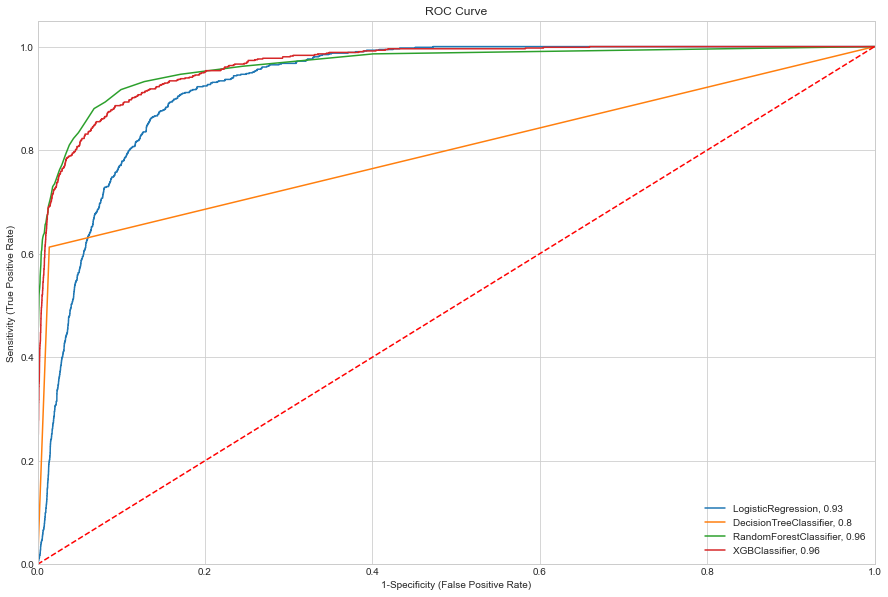

<Figure size 432x288 with 0 Axes>

In [6]:
classification_models = [LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=-1), DecisionTreeClassifier(), RandomForestClassifier(class_weight='balanced'), XGBClassifier()]
model_comparison(classification_models, X_train, y_train, X_test, y_test);

Accuracy is not a valid evaluation metric because of the class imbalance.

Which is worse: **FP** or **FN**?

*Reason shows a **FN** (like ignoring a fire alarm) is MUCH WORSE.*

$$Recall = \frac{TP}{TP + FN}$$

Therefore **Recall** is the best metric to evaluate the models by. Therefore out-of-box Random Forest outperforms XGB.

In [16]:
rf = RandomForestClassifier(class_weight='balanced')
rf_train_scores = cross_val_score(rf, X_train, y_train,
                           scoring='recall', cv=30, n_jobs=-1)
print('RF OOB Training Recall', round(np.mean(rf_train_scores),4))

rf_test_scores = cross_val_score(rf, X_test, y_test,
                           scoring='recall', cv=30, n_jobs=-1)
print('RF OOB Validation Recall', round(np.mean(rf_test_scores),4))

RF OOB Training Recall 0.4046


/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RF OOB Validation Recall 0.1697


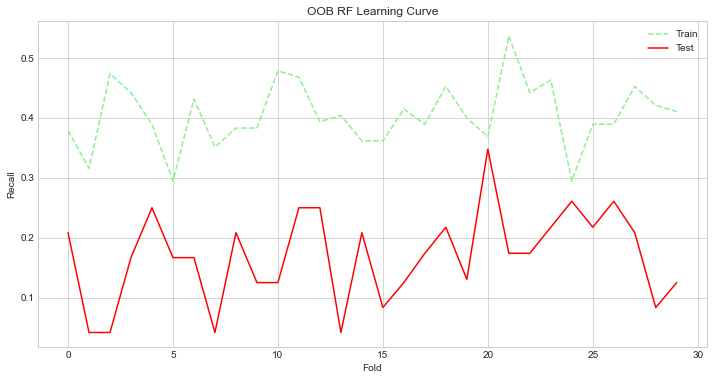

In [27]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(0, len(rf_train_scores)), rf_train_scores, linestyle='--', c='lightgreen', label='Train')
ax.plot(range(0, len(rf_test_scores)), rf_test_scores, c='red', label='Test')
ax.set_title('OOB RF Learning Curve')
ax.set_xlabel('Fold')
ax.set_ylabel('Recall')
ax.legend();

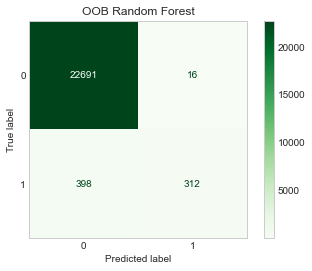

In [18]:
rf.fit(X_train, y_train)
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Greens)
plt.title('OOB Random Forest')
plt.grid(False);

In [19]:
xgb = XGBClassifier()
xgb_train_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=30, n_jobs=-1)
print('XGB OOB Training Recall', round(np.mean(xgb_train_scores),4))

xgb_test_scores = cross_val_score(xgb, X_test, y_test,
                           scoring='recall', cv=30, n_jobs=-1)
print('XGB OOB Validation Recall', round(np.mean(xgb_test_scores),4))

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


XGB OOB Training Recall 0.3842
XGB OOB Validation Recall 0.2597


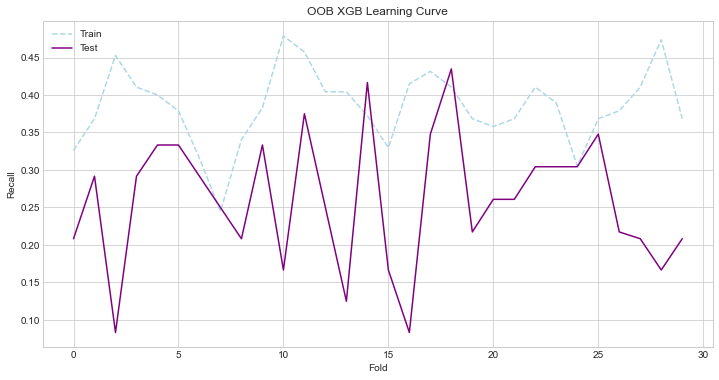

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(0, len(xgb_train_scores)), xgb_train_scores, linestyle='--', c='lightblue', label='Train')
ax.plot(range(0, len(xgb_test_scores)), xgb_test_scores, c='purple', label='Test')
ax.set_title('OOB XGB Learning Curve')
ax.set_xlabel('Fold')
ax.set_ylabel('Recall')
ax.legend();

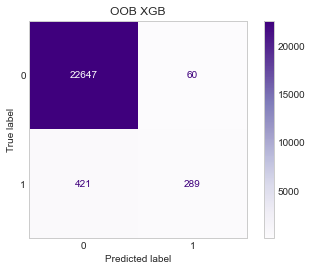

In [23]:
xgb.fit(X_train, y_train)
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('OOB XGB')
plt.grid(False);

*Both RF and XGB are underfitting. XGB outperforms RF OOB on validation set ever so slightly with cross validation. Next step: GridSearchCV or RandomizedSearchCV*

## GridSearchCV
---
Tuning Random Forest with GridSearchCV

In [29]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
rf_parameter_grid = {
    'max_depth': [10, 30, 50, 70],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400, 500, 600]
}

In [32]:
rf_params, rf_gridsearch = gridsearch_with_output(RandomForestClassifier(class_weight='balanced'), 
                                                  rf_parameter_grid, X_train, y_train)

filename = 'tuned-rf.pkl'
pickle.dump(rf_gridsearch, open(filename, 'wb'))

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 189 out of 192 | elapsed: 48.8min remaining:   46.5s
[Parallel(n_jobs=-1)]: Done 192 out 


Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | 10       | [10, 30, 50, 70]
min_samples_leaf     | 4        | [2, 4]
min_samples_split    | 5        | [2, 5]
n_estimators         | 400      | [200, 400, 500, 600]


In [34]:
f = open('tuned-rf.pkl', 'rb')
best_rf = pickle.load(f)

rf_train_scores = cross_val_score(best_rf, X_train, y_train,
                           scoring='recall', cv=30, n_jobs=-1)
print('Tuned RF Training Recall', round(np.mean(rf_train_scores),4))

rf_test_scores = cross_val_score(best_rf, X_test, y_test,
                           scoring='recall', cv=30, n_jobs=-1)
print('Tuned RF Validation Recall', round(np.mean(rf_test_scores),4))

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned RF Training Recall 0.8451


/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned RF Validation Recall 0.7731


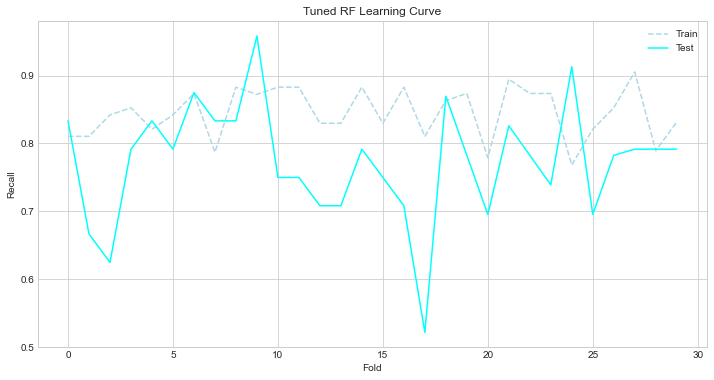

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(0, len(rf_train_scores)), rf_train_scores, linestyle='--', c='lightblue', label='Train')
ax.plot(range(0, len(rf_test_scores)), rf_test_scores, c='aqua', label='Test')
ax.set_title('Tuned RF Learning Curve')
ax.set_xlabel('Fold')
ax.set_ylabel('Recall')
ax.legend();

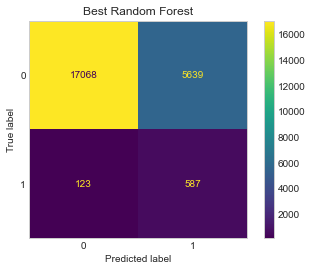

In [36]:
best_rf.fit(X_train, y_train)
plot_confusion_matrix(best_rf, X_test, y_test, cmap=plt.get_cmap('viridis'))
plt.title('Best Random Forest')
plt.grid(False);

Tuning XGB with GridSearchCV

In [30]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [37]:
xgb_parameter_grid = {
                    'max_depth': [6, 9],
                    'n_estimators': [200, 400, 500, 600], 
                    'learning_rate': [0.1, 0.2],
                    'lambda': [0.5, 0.8], # l2 regualrization
                    'alpha': [0.25, 0.5]  # l1 regularization
                    }

In [38]:
xgb_params, xgb_gridsearch = gridsearch_with_output(XGBClassifier(), 
                                                    xgb_parameter_grid, X_train, y_train)

filename = 'tuned-xgb.pkl'
pickle.dump(xgb_gridsearch, open(filename, 'wb'))

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.4min
/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 37.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 61.5min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 86.1min
[Parallel(n_jobs=-1)]: Done 12


Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
max_depth            | 6        | [6, 9]
n_estimators         | 600      | [200, 400, 500, 600]
learning_rate        | 0.2      | [0.1, 0.2]
lambda               | 0.5      | [0.5, 0.8]
alpha                | 0.25     | [0.25, 0.5]


In [39]:
f = open('tuned-xgb.pkl', 'rb')
best_xgb = pickle.load(f)

xgb_train_scores = cross_val_score(best_xgb, X_train, y_train,
                           scoring='recall', cv=30, n_jobs=-1)
print('Tuned RF Training Recall', round(np.mean(xgb_train_scores),4))

xgb_test_scores = cross_val_score(best_xgb, X_test, y_test,
                           scoring='recall', cv=30, n_jobs=-1)
print('Tuned RF Validation Recall', round(np.mean(xgb_test_scores),4))

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Tuned RF Training Recall 0.5556
Tuned RF Validation Recall 0.3272


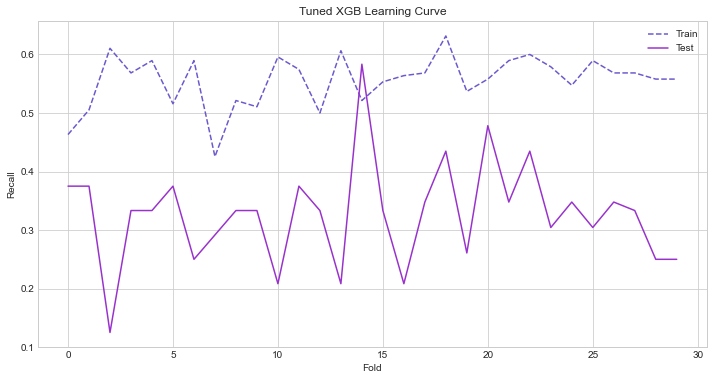

In [40]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(0, len(xgb_train_scores)), xgb_train_scores, linestyle='--', c='slateblue', label='Train')
ax.plot(range(0, len(xgb_test_scores)), xgb_test_scores, c='darkorchid', label='Test')
ax.set_title('Tuned XGB Learning Curve')
ax.set_xlabel('Fold')
ax.set_ylabel('Recall')
ax.legend();

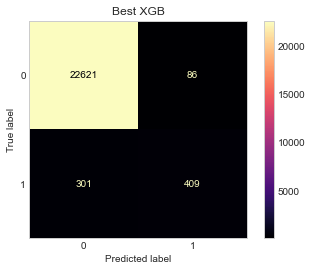

In [41]:
best_xgb.fit(X_train, y_train)
plot_confusion_matrix(best_xgb, X_test, y_test, cmap=plt.get_cmap('magma'))
plt.title('Best XGB')
plt.grid(False);

## Final Model: Random Forest

In [55]:
rf_accuracy, rf_precision, rf_recall, rf_f1 = cross_val(best_rf, X_train, y_train, X_test, y_test, splits=30)

print(f'Final model scores:\nRecall: {round(rf_recall,4)}\nPrecision: {round(rf_precision,4)}\nF1 Score: {round(rf_f1,4)}\nAccuracy: {round(rf_accuracy,4)}')

Final model scores:
Recall: 0.8419
Precision: 0.0961
F1 Score: 0.1724
Accuracy: 0.7551
